# What Gravitational wave Template fits GW150914 the best? #

Try to fit the LIGO detector data of the GW150914 binary black hole merger to a gravitational-wave template. You can adjust the masses and the spin of the template with the sliders below and see how well it matches up to the data, and how much signal-to-noise you are able to extract.

In [4]:
#%%capture
#!pip install pycbc lalsuite
#import ipywidgets as gui
# Let's get the data size a bit more maneageable
from pycbc.catalog import Merger
from pycbc.filter import highpass, resample_to_delta_t
m = Merger("GW150914")
data = {}
#for ifo in ["H1", "L1"]:
#    ts = m.strain(ifo)
#    ts = highpass(ts, 30.0)
#    ts = resample_to_delta_t(ts, 1.0/1024)
#    data[ifo] = ts
#    ts.save('gw150914.hdf', group=ifo)

In [5]:
import pycbc.types
ifos = ['H1', 'L1']
data = {ifo:pycbc.types.load_timeseries('gw150914.hdf', group=ifo) for ifo in ifos}    
from pycbc.psd import interpolate, inverse_spectrum_truncation
psd = {}

for ifo in ifos:
    psd[ifo] = interpolate(data[ifo].psd(4), data[ifo].delta_f)
    psd[ifo] = inverse_spectrum_truncation(psd[ifo], 4 * data[ifo].sample_rate,
                                           low_frequency_cutoff=15.0)
    
wdata = {}
for ifo in ifos:
    wdata[ifo] = data[ifo].whiten(4, 4).lowpass_fir(300, 1024).highpass_fir(30, 1024)

In [6]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.filter import sigma
def make_snr(ifo, m1, m2, s12):
    hp, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=m1, mass2=m2, spin1z=s12, spin2z=s12,
                             f_lower=25, delta_f=data[ifo].delta_f)
    hp.resize(len(data[ifo])/2+1)
    
    snr = matched_filter(hp, data[ifo], psd=psd[ifo], low_frequency_cutoff=30.0)
    
    sp = snr.time_slice(m.time - 1, m.time + 1)
    a = sp.abs_arg_max()
    spm = sp[a]
    snr = snr.time_slice(m.time-.35, m.time+.35)
    dt = sp.sample_times[a] - data[ifo].start_time
    hp.start_time = data[ifo].start_time + dt
    snr.template = (hp / sigma(hp, psd=psd[ifo], low_frequency_cutoff=30.0) * spm).cyclic_time_shift(dt)
    snr.template = (snr.template / psd[ifo] ** 0.5).to_timeseries().crop(4, 4).lowpass_fir(300, 1024).highpass_fir(30, 1024)
    return snr

<IPython.core.display.Javascript object>


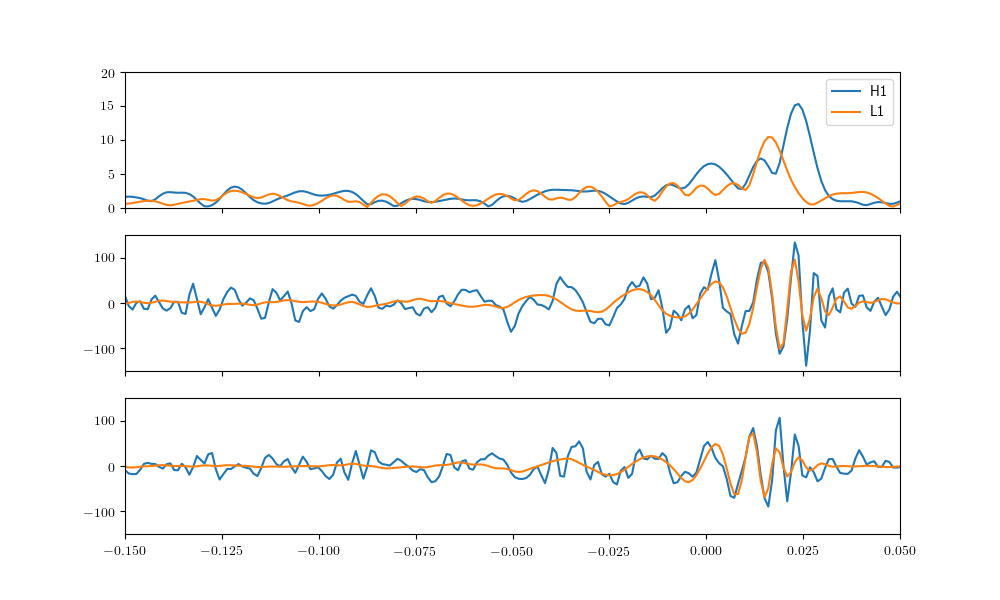

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTUwLjAsIGRlc2NyaXB0aW9uPXUnJE1fMSAoTV9cXG9kb3QkKScsIGxheW91dD1MYXlvdXQod2lkdGg9dScxMDAlJyksIG3igKY=


In [7]:
%matplotlib notebook
import pylab
pylab.rc('text', usetex=True)
pax = {}
fig, (ax1, pax['H1'], pax['L1']) = pylab.subplots(3, 1, figsize=[10, 6], sharex=True)

ax1.set_ylim(0, 20)
lines = {}
lt = {}

for ifo in ifos:
    snr = make_snr(ifo, 37, 37, 0)
    lines[ifo], = ax1.plot(snr.sample_times.numpy()-m.time, abs(snr).numpy(), label=ifo)
    
    pax[ifo].plot(wdata[ifo].sample_times-m.time, wdata[ifo])
    lt[ifo], = pax[ifo].plot(snr.template.sample_times-m.time, snr.template)
    pax[ifo].set_ylim(-150, 150)
    
ax1.legend()
pylab.xlim(-0.15, +0.05)



def p(m1, m2, s12):
    for ifo in ifos:
        snr = make_snr(ifo, m1, m2, s12)
        lines[ifo].set_ydata(abs(snr).numpy())
        lt[ifo].set_ydata(snr.template.numpy())
        
    fig.canvas.draw_idle()

import ipywidgets as gui

mslider = gui.FloatSlider(value=50, max=100, min=20,
                                readout_format='.1f',
                                layout=gui.Layout(width='100%'),
                                description='$M_1 (M_\odot$)',
                                step=0.5, continuous_update=True)
mslider2 = gui.FloatSlider(value=50, max=100, min=20,
                                readout_format='.1f',
                                layout=gui.Layout(width='100%'),
                                description='$M_2 (M_\odot$)',
                                step=0.5, continuous_update=True)
spinslider = gui.FloatSlider(value=0, max=.95, min=-.95,
                                readout_format='.2f',
                                layout=gui.Layout(width='100%', height='100%'),
                                description='Spin',
                                step=0.05, continuous_update=True)
out = gui.interact(p, 
             m1=mslider,
             m2=mslider2,
             s12=spinslider,
             )
pylab.show()